# Recreation of "200811 Fastq kmer counts basic comparison" with 17AC0012455-1A_S1_L001_R1_001

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import h5py as h5
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
from gambit.seq import SequenceFile
from gambit.kmers import KmerSpec, find_kmers
from gambit.sigs import load_signatures
from gambit_pub.fastq import get_phred, phredsum

## Code

In [5]:
# Histogram with transparency fill
def myhist(ax, x, color, alpha=.25, lw=2, **kw):
    h1 = ax.hist(x, fc=color, alpha=alpha, **kw)
    h2 = ax.hist(x, histtype='step', ec=color, lw=lw, **kw)
    return (h1, h2)

## Setup

### Parameters

In [6]:
kspec = KmerSpec(11, 'ATGAC')

In [7]:
phred_thresholds = [10, 15, 20, 25]

### Input files

In [8]:
wf_path = Path('/home/jared/code/gambit/gambit-publication/')

In [9]:
filename = '17AC0012455-1A_S1_L001_R1_001'

In [10]:
fastq_path = wf_path / f'resources/genomes/set3/fastq/{filename}.fastq.gz'
fastq_file = SequenceFile(fastq_path, 'fastq', 'gzip')

fasta_path = wf_path / f'resources/genomes/set3/fasta/{filename}.fasta'
fasta_file = SequenceFile(fasta_path, 'fasta', None)

sigs_path = wf_path / f'intermediate-data/signatures/set3-{kspec.k}-{kspec.prefix_str}.h5'

### Signature

In [11]:
sigs = load_signatures(sigs_path)

In [12]:
(sig_idx,) = np.flatnonzero(sigs.ids == (filename + '.fasta'))

In [13]:
sig = sigs[sig_idx]

## Raw read counts

In [14]:
read_counts = np.zeros((kspec.nkmers, len(phred_thresholds)), dtype=np.int16)
n_invalid = 0

for record in tqdm(fastq_file.parse()):
    phred = get_phred(record)
    
    for match in find_kmers(kspec, record.seq):
        try:
            idx = match.kmer_index()
        except ValueError:
            n_invalid += 1
            continue
            
        phred_agg = phredsum(phred[match.full_indices()])
        phred_bin = np.searchsorted(phred_thresholds, phred_agg, 'right') - 1
        if phred_bin >= 0:
            read_counts[idx, phred_bin] += 1

2275970it [01:28, 25827.69it/s]


In [15]:
read_counts_cum = np.cumsum(read_counts[:, ::-1], axis=1)[:, ::-1]

In [16]:
in_fastq = [np.flatnonzero(read_counts_cum[:, i]) for i in range(4)]

## Assembly counts

In [17]:
assembly_counts = np.zeros(kspec.nkmers, dtype=np.int16)

In [18]:
fasta_ncontigs = 0

for record in fasta_file.parse():
    fasta_ncontigs += 1

    for match in find_kmers(kspec, record.seq):
        assembly_counts[match.kmer_index()] += 1

fasta_ncontigs

1826

In [19]:
np.count_nonzero(assembly_counts)

5019

In [20]:
in_fasta = np.flatnonzero(assembly_counts)
fastq_in_fasta = [np.in1d(in_fastq[i], in_fasta) for i in range(4)]

## Plots

Text(0.5, 0.98, 'Kmer counts in assembly')

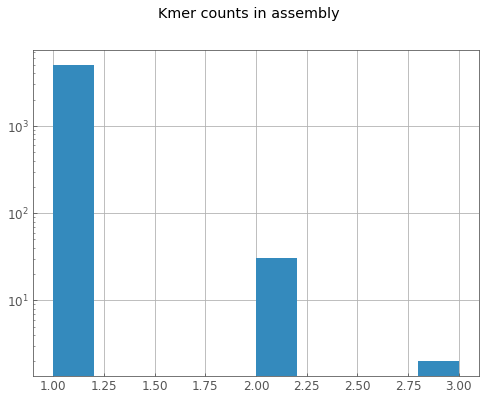

In [21]:
plt.hist(assembly_counts[assembly_counts > 0], bins=10, log=True)
plt.suptitle("Kmer counts in assembly")

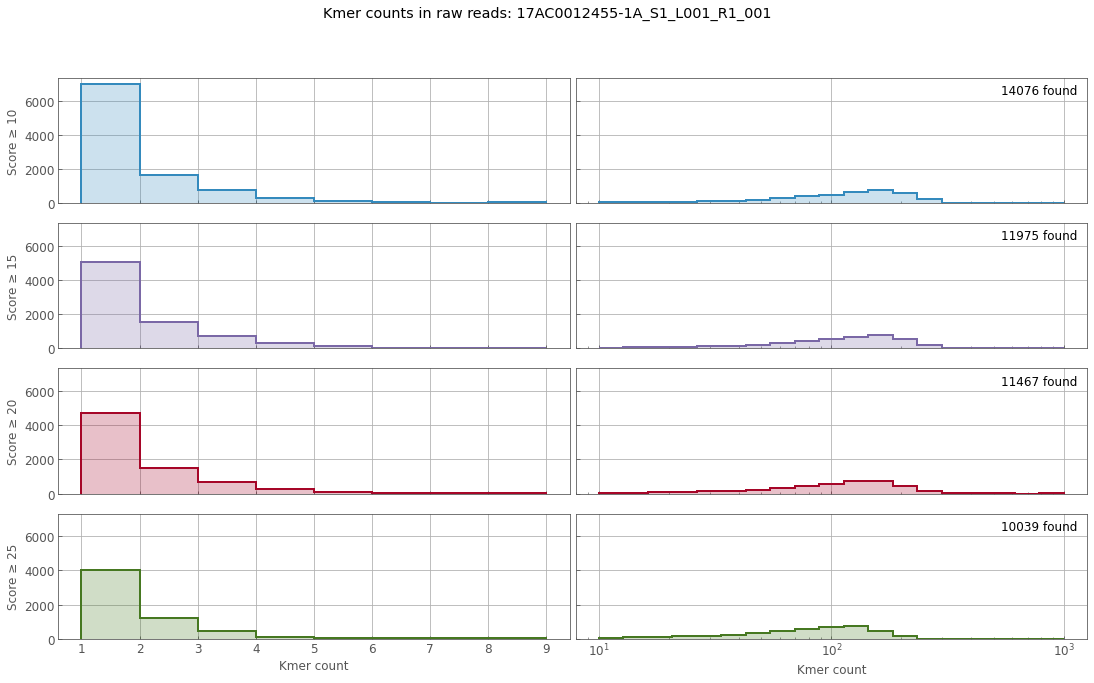

In [32]:
fig, axs = plt.subplots(4, 2, sharex='col', sharey=True, figsize=(16, 10))
pal = sns.color_palette(n_colors=len(phred_thresholds))

bins1 = np.arange(1, 10)
bins2 = 10 ** np.linspace(1, 3, 20)

for (i, t) in enumerate(phred_thresholds):
    ax1, ax2 = axs[i, :]

    vals = read_counts_cum[:, i]
    myhist(ax1, vals, pal[i], bins=bins1)
    myhist(ax2, vals, pal[i], bins=bins2)

    ax1.set_ylabel(f"Score ≥ {t}")

    cnt = np.count_nonzero(read_counts_cum[:, i])
    ax2.text(.98, .95, f"{cnt} found",
        transform=ax2.transAxes, va='top', ha='right')

axs[3, 1].set_xscale('log')
axs[3, 0].set_xlabel("Kmer count")
axs[3, 1].set_xlabel("Kmer count")
plt.suptitle(f"Kmer counts in raw reads: {filename}")
plt.tight_layout(pad=3, w_pad=.5, h_pad=1)

Text(0.5, 0.98, 'Kmer counts in raw reads: 17AC0012455-1A_S1_L001_R1_001')

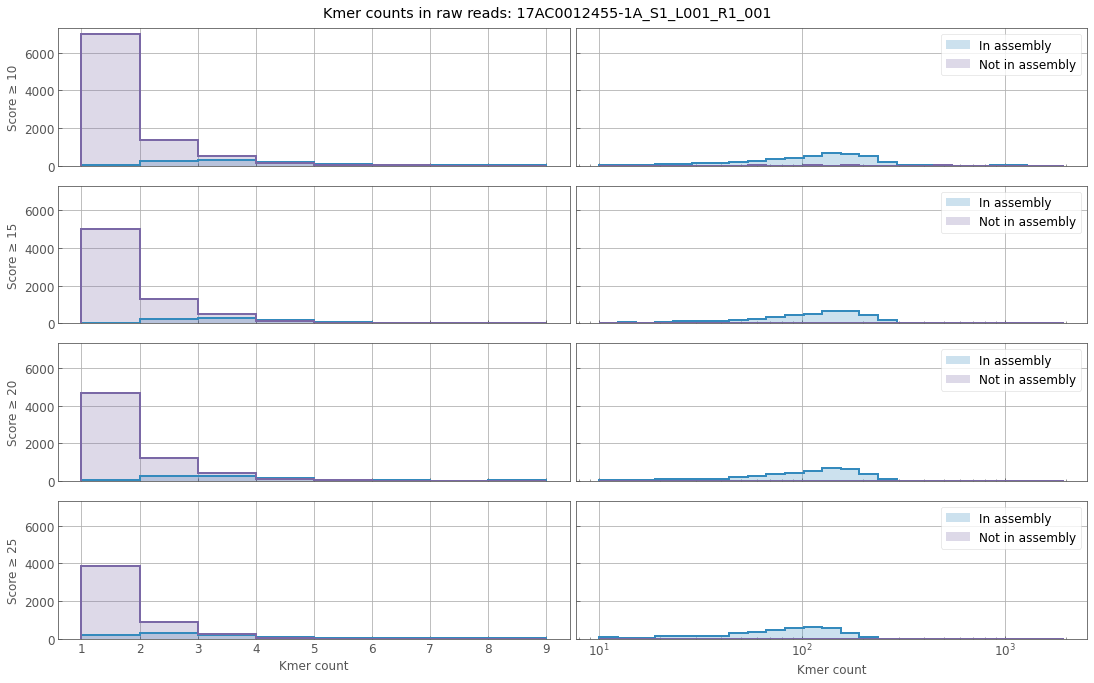

In [33]:
fig, axs = plt.subplots(len(phred_thresholds), 2, sharex='col', sharey=True, figsize=(16, 10))

max_read = np.max(read_counts_cum)
nbins = 25
bins1 = np.arange(1, 10)
bins2 = 10 ** np.linspace(1, np.log10(max_read+1), nbins+1)

pal = sns.color_palette(n_colors=2)
alpha = 0.25

for i, thresh in enumerate(phred_thresholds):
    ax1, ax2 = axs[i, :]
    read_counts2 = read_counts_cum[in_fastq[i], i]
    max_read = np.max(read_counts2)

    ax2.set_xscale('log')
    ax1.set_ylabel(f"Score ≥ {thresh}")

    for (ax, bins) in zip([ax1, ax2], [bins1, bins2]):
        h1 = myhist(ax, 
            read_counts2[fastq_in_fasta[i]],
            pal[0],
            bins=bins)
        h2 = myhist(ax, 
            read_counts2[~fastq_in_fasta[i]],
            pal[1],
            bins=bins)
    
    ax2.legend([h1[0][2][0], h2[0][2][0]], ["In assembly", "Not in assembly"])

axs[3, 0].set_xlabel("Kmer count")
axs[3, 1].set_xlabel("Kmer count")

fig.tight_layout(pad=3, w_pad=.5, h_pad=1)
plt.suptitle(f"Kmer counts in raw reads: {filename}")

## Accuracy

In [24]:
count_thresholds = [*range(1, 6), 10]

In [25]:
rows = []

for (i, score_thresh) in enumerate(phred_thresholds):
    _fastq_counts = read_counts_cum[in_fastq[i], i]
    for count_thresh in count_thresholds:
        
        _fastq_over = _fastq_counts >= count_thresh
        _c_fastq_fasta = np.sum(_fastq_over[fastq_in_fasta[i]])
        _c_fastq_only = np.sum(_fastq_over[~fastq_in_fasta[i]])
        _c_fasta_only = len(in_fasta) - _c_fastq_fasta
        _c_none = kspec.nkmers - _c_fastq_fasta - _c_fastq_only - _c_fasta_only
        
        rows.append((score_thresh, count_thresh, True, True, _c_fastq_fasta))
        rows.append((score_thresh, count_thresh, True, False, _c_fastq_only))
        rows.append((score_thresh, count_thresh, False, True, _c_fasta_only))
        rows.append((score_thresh, count_thresh, False, False, _c_none))

cols = ['score_threshold', 'count_threshold', 'in_reads', 'in_assembly', 'count']
counts_df = pd.DataFrame.from_records(rows, columns=cols).set_index(cols[:-1])
counts_df.sort_index(inplace=True)

In [26]:
assert all(counts_df.groupby(['score_threshold', 'count_threshold'])['count'].sum() == kspec.nkmers)

In [27]:
counts_df

count
score_threshold count_threshold in_reads in_assembly         
10              1               False    False        4180212
                                         True              16
                                True     False           9073
                                         True            5003
                2               False    False        4187188
...                                                       ...
25              5               True     True            4195
                10              False    False        4189266
                                         True             940
                                True     False             19
                                         True            4079

[96 rows x 1 columns]

In [28]:
rows = []
kmer_in_assembly = assembly_counts >= 1

for (i, score_thresh) in enumerate(phred_thresholds):
    for count_thresh in count_thresholds:
        kmer_in_read = read_counts[:, i] >= count_thresh
        for in_read in [False, True]:
            for in_assembly in [False, True]:
                c = np.sum((kmer_in_read == in_read) & (kmer_in_assembly == in_assembly))
                rows.append((score_thresh, count_thresh, in_read, in_assembly, c))

cols = ['score_threshold', 'count_threshold', 'in_reads', 'in_assembly', 'count']
counts_df2 = pd.DataFrame.from_records(rows, columns=cols).set_index(cols[:-1])
counts_df2.sort_index(inplace=True)

In [29]:
assert all(counts_df2.groupby(['score_threshold', 'count_threshold'])['count'].sum() == kspec.nkmers)

In [36]:
rows = []
keys = []

for key, g in counts_df.groupby(['score_threshold', 'count_threshold']):
    g = g['count'].reset_index(['score_threshold', 'count_threshold'], drop=True)
    tp = g.loc[True, True]
    fp = g.loc[True, False]
    fn = g.loc[False, True]
    rows.append([tp / (tp + fp), tp / (tp + fn), 1 - tp / (tp + fn + fp)])
    keys.append(key)
    
pr_df = pd.DataFrame.from_records(
    rows,
    columns=['precision', 'recall', 'jaccard'],
    index=pd.MultiIndex.from_tuples(keys, names=['score_threshold', 'count_threshold']),
)

In [37]:
pr_df

precision    recall   jaccard
score_threshold count_threshold                               
10              1                 0.355428  0.996812  0.644976
                2                 0.704190  0.994620  0.298482
                3                 0.868166  0.946005  0.172822
                4                 0.955760  0.891014  0.144279
                5                 0.983467  0.853357  0.158711
                10                0.995418  0.822475  0.180627
15              1                 0.417704  0.996613  0.582889
                2                 0.718367  0.992030  0.285755
                3                 0.876877  0.942220  0.167869
                4                 0.958468  0.887428  0.145434
                5                 0.983886  0.851564  0.160149
                10                0.995413  0.821478  0.181620
20              1                 0.436121  0.996414  0.564562
                2                 0.734333  0.985256  0.273649
                3                 0.891284  0.931062  0.163893
                4                 0.965396  0.878263  0.148542
                5                 0.986324  0.847778  0.162072
                10                0.995405  0.820084  0.183009
25              1                 0.494770  0.989639  0.507779
                2                 0.799167  0.955370  0.229595
                3                 0.935632  0.892010  0.159564
                4                 0.984138  0.852959  0.158608
                5                 0.993134  0.835824  0.168978
                10                0.995364  0.812712  0.190353

In [40]:
pr_df.iloc[np.argmin(pr_df['jaccard'])]

precision    0.955760
recall       0.891014
jaccard      0.144279
Name: (10, 4), dtype: float64